# William Nickerson Rec. Center CalEnvironScreen Map

In [1]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

# for interactive webmaps
import folium

In [2]:
latlon = [33.93243952987771, -118.24696245126037] # Already Centered a bad park in District 2 according to our metrics
network_type = 'walk' # Change network type because I am focusing on transportation
trip_times = [5, 10, 15, 20] #in minutes, 
meters_per_minute = 75 # travel distance per minute for a car going 25 mph

In [3]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000) # standard

In [4]:
G = ox.project_graph(G, to_crs='epsg:3857')

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [6]:
# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13165595.987373214
4017340.6220267233
-13160779.749604043
4022144.7596882777


In [7]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13163187.868488628
4019742.690857501


In [8]:
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x) # Defining this for later, just as the park center

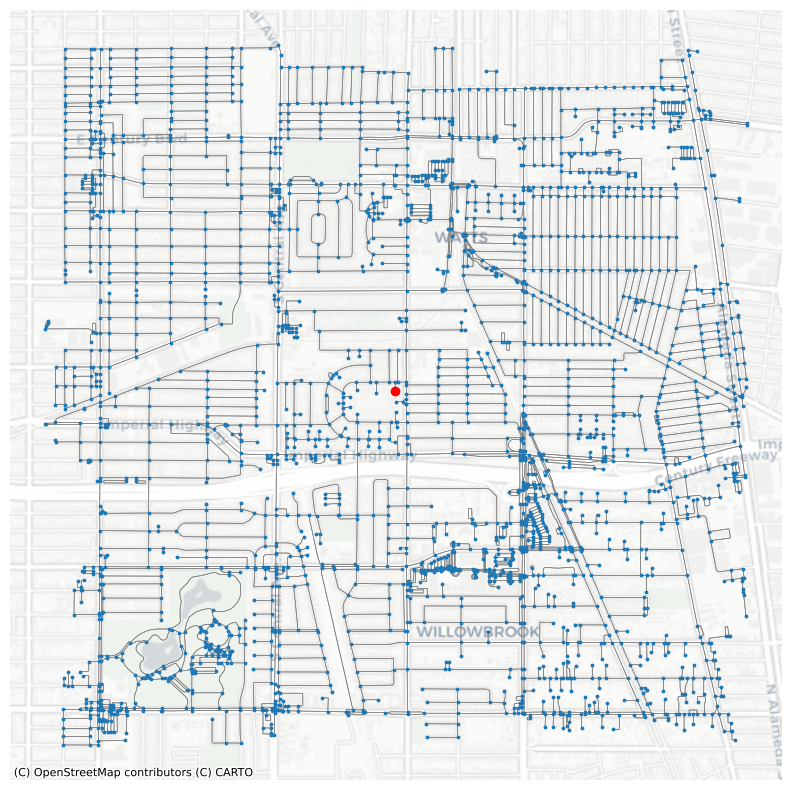

In [9]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5, # don't do more than 1
               edgecolor='gray', # line color
               zorder=10) #3D position (layers)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=3, 
               zorder=20) #this is higher so goes over the lines

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30) # top-most layers

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

# post note: that worked out well because the centroid is focused on the parking lot entrance to the park, where Walkrs would access it. 

In [10]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [11]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(15)

osmid                       name  \
u           v          key                                          
9430696816  9430706432 0    1022543868  East El Segundo Boulevard   
8411330872  7271751623 0     812743367                        NaN   
1268311664  7366418204 0     248619904                        NaN   
122964336   2445108005 0      13346032              Zamora Avenue   
6808045486  1775532198 0      13392898          East 115th Street   
4619370901  4619370900 0     467290165                        NaN   
3701384265  293916909  0     166067254             Mona Boulevard   
3573809754  3573809748 0     351574120                        NaN   
6807288341  122719410  0      13444835          East 116th Street   
6302939350  6302939351 0     673051778                        NaN   
122747289   1718680533 0      13435800               Anzac Avenue   
122914029   1719010819 0      25434266           East 97th Street   
2554953930  122911481  0      13336275          East 110th Street   
2117126824  2117126321 0     201699630                        NaN   
10181176587 122917554  0      13385985              Clovis Avenue   

                                highway   length  walk_time  
u           v          key                                   
9430696816  9430706432 0        primary   10.769   0.143587  
8411330872  7271751623 0        service   19.860   0.264800  
1268311664  7366418204 0        service   65.778   0.877040  
122964336   2445108005 0    residential   47.736   0.636480  
6808045486  1775532198 0    residential   56.911   0.758813  
4619370901  4619370900 0        service   26.682   0.355760  
3701384265  293916909  0    residential   41.593   0.554573  
3573809754  3573809748 0        service   18.327   0.244360  
6807288341  122719410  0    residential   44.176   0.589013  
6302939350  6302939351 0        service   47.053   0.627373  
122747289   1718680533 0    residential  230.132   3.068427  
122914029   1719010819 0       tertiary   50.789   0.677187  
2554953930  122911481  0    residential  100.087   1.334493  
2117126824  2117126321 0        footway  245.892   3.278560  
10181176587 122917554  0    residential  109.673   1.462307

## I get it now.
It took me a while to understand this but I get it. The Walk_time is a function of the length of the edges, not the time to get to the centroid. I have to say it again so I don't forget.

In [12]:
cmap = 'RdYlGn_r'

In [13]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15, 20]
['#006837', '#b7e075', '#fdbf6f', '#a50026']


In [14]:
iso_colors.reverse()
iso_colors

['#a50026', '#fdbf6f', '#b7e075', '#006837']

In [15]:
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#a50026'), (10, '#fdbf6f'), (15, '#b7e075'), (20, '#006837')]

In [16]:
for time,color in list(time_color):
    print('The color for a '+str(time)+' minute Walk is ' + color) # change this a tiny bit for grammer

The color for a 5 minute Walk is #a50026
The color for a 10 minute Walk is #fdbf6f
The color for a 15 minute Walk is #b7e075
The color for a 20 minute Walk is #006837


In [17]:
time_color.reverse()
time_color

[(20, '#006837'), (15, '#b7e075'), (10, '#fdbf6f'), (5, '#a50026')]

In [18]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node, radius=time,distance='time') #centernode is the park, defined earlier 

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' a minute Walk ' + color)
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 802 nodes within 20 a minute Walk #006837
There are 312 nodes within 15 a minute Walk #b7e075
There are 101 nodes within 10 a minute Walk #fdbf6f
There are 20 nodes within 5 a minute Walk #a50026


In [19]:
gdf_nodes.sample(10)

y             x highway  street_count         lon  \
osmid                                                                       
6807334498   4.019657e+06 -1.316355e+07     NaN             3 -118.250195   
2553883223   4.020381e+06 -1.316516e+07     NaN             4 -118.264613   
1288225186   4.019922e+06 -1.316162e+07     NaN             1 -118.232819   
122719638    4.019649e+06 -1.316546e+07     NaN             3 -118.267340   
10181196375  4.018072e+06 -1.316449e+07     NaN             3 -118.258622   
5572538097   4.018642e+06 -1.316292e+07     NaN             3 -118.244539   
3695625318   4.017461e+06 -1.316204e+07     NaN             1 -118.236616   
4129514389   4.019780e+06 -1.316410e+07     NaN             1 -118.255094   
7810297450   4.021679e+06 -1.316132e+07     NaN             3 -118.230173   
277176950    4.020596e+06 -1.316284e+07     NaN             3 -118.243782   

                   lat                           geometry  time    color  
osmid                                                                     
6807334498   33.931864  POINT (-13163551.482 4019656.638)  10.0  #fdbf6f  
2553883223   33.937260  POINT (-13165156.465 4020380.658)  20.0  #006837  
1288225186   33.933841  POINT (-13161617.217 4019921.877)   NaN      nan  
122719638    33.931804  POINT (-13165460.066 4019648.668)   NaN      nan  
10181196375  33.920054  POINT (-13164489.550 4018072.223)   NaN      nan  
5572538097   33.924298  POINT (-13162921.826 4018641.648)  20.0  #006837  
3695625318   33.915494  POINT (-13162039.875 4017460.612)   NaN      nan  
4129514389   33.932781  POINT (-13164096.881 4019779.737)  20.0  #006837  
7810297450   33.946935  POINT (-13161322.688 4021678.930)   NaN      nan  
277176950    33.938862  POINT (-13162837.646 4020595.651)  15.0  #b7e075

In [20]:
import numpy as np
gdf_nodes['color'] = gdf_nodes['color'].replace('nan', np.nan)
gdf_nodes = gdf_nodes.dropna(subset=['color'])
gdf_nodes

y             x          highway  street_count  \
osmid                                                                    
24043752     4.019538e+06 -1.316400e+07  traffic_signals             4   
7821947706   4.019538e+06 -1.316394e+07              NaN             3   
122594633    4.019827e+06 -1.316400e+07  traffic_signals             3   
25522192     4.019334e+06 -1.316401e+07  traffic_signals             4   
1775545728   4.019537e+06 -1.316415e+07              NaN             3   
...                   ...           ...              ...           ...   
11395424011  4.020399e+06 -1.316402e+07              NaN             3   
11395424010  4.020430e+06 -1.316402e+07              NaN             1   
11399698387  4.020271e+06 -1.316316e+07              NaN             1   
11399698389  4.020249e+06 -1.316315e+07              NaN             1   
11715717164  4.021198e+06 -1.316371e+07              NaN             1   

                    lon        lat                           geometry  time  \
osmid                                                                         
24043752    -118.254267  33.930978  POINT (-13164004.798 4019537.846)  15.0   
7821947706  -118.253726  33.930981  POINT (-13163944.563 4019538.181)  15.0   
122594633   -118.254251  33.933131  POINT (-13164002.983 4019826.630)  15.0   
25522192    -118.254277  33.929462  POINT (-13164005.889 4019334.370)  15.0   
1775545728  -118.255553  33.930972  POINT (-13164147.943 4019537.068)  15.0   
...                 ...        ...                                ...   ...   
11395424011 -118.254425  33.937399  POINT (-13164022.431 4020399.362)  15.0   
11395424010 -118.254424  33.937627  POINT (-13164022.275 4020429.861)  15.0   
11399698387 -118.246716  33.936446  POINT (-13163164.258 4020271.426)  10.0   
11399698389 -118.246632  33.936277  POINT (-13163154.818 4020248.844)  10.0   
11715717164 -118.251581  33.943351  POINT (-13163705.782 4021197.997)  20.0   

               color  
osmid                 
24043752     #b7e075  
7821947706   #b7e075  
122594633    #b7e075  
25522192     #b7e075  
1775545728   #b7e075  
...              ...  
11395424011  #b7e075  
11395424010  #b7e075  
11399698387  #fdbf6f  
11399698389  #fdbf6f  
11715717164  #006837  

[802 rows x 9 columns]

In [21]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones
# make the polygons by the time intervals

geometry             y  \
time                                                                    
5.0   MULTIPOINT ((-13163459.187 4019829.756), (-131...  4.020186e+06   
10.0  MULTIPOINT ((-13163997.284 4020217.031), (-131...  4.019554e+06   
15.0  MULTIPOINT ((-13164819.267 4019850.284), (-131...  4.019538e+06   
20.0  MULTIPOINT ((-13165528.105 4019556.589), (-131...  4.019547e+06   

                 x          highway  street_count         lon        lat  \
time                                                                       
5.0  -1.316312e+07  traffic_signals             4 -118.246287  33.935807   
10.0 -1.316280e+07  traffic_signals             3 -118.243453  33.931100   
15.0 -1.316400e+07  traffic_signals             4 -118.254267  33.930978   
20.0 -1.316518e+07  traffic_signals             3 -118.264844  33.931046   

        color  
time           
5.0   #a50026  
10.0  #fdbf6f  
15.0  #b7e075  
20.0  #006837

In [22]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones
# make the polygon outta the nodes

time                                           geometry
0   5.0  POLYGON ((-13163116.401 4019747.040, -13163324...
1  10.0  POLYGON ((-13163888.135 4019538.476, -13163944...
2  15.0  POLYGON ((-13162496.252 4018865.047, -13163455...
3  20.0  POLYGON ((-13163481.006 4017582.802, -13165528...

In [23]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones.rename(columns={'time': 'Walk Time (min)'}, inplace=True)
isochrones

Walk Time (min)                                           geometry
3             20.0  POLYGON ((-13163481.006 4017582.802, -13165528...
2             15.0  POLYGON ((-13162496.252 4018865.047, -13163455...
1             10.0  POLYGON ((-13163888.135 4019538.476, -13163944...
0              5.0  POLYGON ((-13163116.401 4019747.040, -13163324...

# Add in other datasets

In [24]:
import pandas as pd 
import geopandas as gpd

In [25]:
# Import CalEnviroScreen Data
ces = pd.read_csv('Data/ces4.0.csv', dtype={'Census Tract': str})
ces['GEO_ID'] = ces['FIPS'].astype(str).str.zfill(11)

In [26]:
Income = pd.read_excel(
    'Data/Income-Data.xlsx',
    dtype=
    {
        'GEO_ID':str,
    }
)
Income = Income.drop([0])
Income.info

<bound method DataFrame.info of       Geometry       GEO_ID  Less_10k  10k_to_14999  15k_to_19999  20k_24999  \
1     1400000U  06037101110        54           126            49         33   
2     1400000U  06037101122        88             0             7         42   
3     1400000U  06037101220        78            82            28        102   
4     1400000U  06037101221        76           107           118        148   
5     1400000U  06037101222       161           167            34         41   
...        ...          ...       ...           ...           ...        ...   
2494  1400000U  06037980038         0             0             0          0   
2495  1400000U  06037980039         0             0             0          0   
2496  1400000U  06037990100         0             0             0          0   
2497  1400000U  06037990200         0             0             0          0   
2498  1400000U  06037990300         0             0             0          0   

      2

In [27]:
Tracts = gpd.read_file('Data/tl_2021_06_tract.zip')

Tracts1 = Tracts[['GEOID','geometry']]
Tracts1.columns = ['GEO_ID',
'geometry']
Tracts1.head()

GEO_ID                                           geometry
0  06085504321  POLYGON ((-121.87556 37.39924, -121.87535 37.3...
1  06085504410  POLYGON ((-121.88886 37.40758, -121.88576 37.4...
2  06085507003  POLYGON ((-122.02489 37.21683, -122.02459 37.2...
3  06085507004  POLYGON ((-121.99304 37.22562, -121.99249 37.2...
4  06085502204  POLYGON ((-121.93167 37.29803, -121.92801 37.3...

In [28]:
District2 = pd.read_excel('Data/District2.xlsx',
    dtype =
    {
        'CT20':str,
    }
)
District2['GEO_ID'] = '06' + '037' + District2['CT20']
District2.head()

OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0          640           2         640  211000  2110.00  2ND SUP. DISTRICT   
1          641           2         641  211121  2111.21  2ND SUP. DISTRICT   
2          642           3         642  211122  2111.22  2ND SUP. DISTRICT   
3          643           2         643  211123  2111.23  2ND SUP. DISTRICT   
4          644           2         644  211124  2111.24  2ND SUP. DISTRICT   

                       SUP_NAME  DIST_SUP CITYNAME_ALF NAME_1  \
0  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
1  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
2  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
3  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   
4  2ND DISTRICT: HOLLY MITCHELL         2  LOS ANGELES    NaN   

        JURISDICTION  AREA_NUM               AREA_NAME   Shape__Area  \
0  INCORPORATED CITY         5  Westside Planning Area  3.881413e+06   
1  INCORPORATED CITY         9     Metro Planning Area  3.125745e+05   
2  INCORPORATED CITY         9     Metro Planning Area  5.341218e+05   
3  INCORPORATED CITY         9     Metro Planning Area  2.513022e+05   
4  INCORPORATED CITY         9     Metro Planning Area  5.771177e+05   

   Shape__Length       GEO_ID  
0    9270.888577  06037211000  
1    2799.117227  06037211121  
2    3050.487937  06037211122  
3    2501.035059  06037211123  
4    3012.923477  06037211124

In [29]:
District2Tracts=Tracts1.merge(District2,on="GEO_ID")
District2Tracts.head()

GEO_ID                                           geometry  \
0  06037541605  POLYGON ((-118.21630 33.90339, -118.21538 33.9...   
1  06037542000  POLYGON ((-118.20734 33.90732, -118.20733 33.9...   
2  06037542401  POLYGON ((-118.21998 33.89600, -118.21985 33.8...   
3  06037542402  POLYGON ((-118.21883 33.88859, -118.21868 33.8...   
4  06037542502  POLYGON ((-118.23599 33.89591, -118.23571 33.8...   

   OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0         1791           1        1791  541605  5416.05  2ND SUP. DISTRICT   
1         1796           2        1796  542000  5420.00  2ND SUP. DISTRICT   
2         1802           1        1802  542401  5424.01  2ND SUP. DISTRICT   
3         1803           2        1803  542402  5424.02  2ND SUP. DISTRICT   
4         1805           1        1805  542502  5425.02  2ND SUP. DISTRICT   

                       SUP_NAME  DIST_SUP CITYNAME_ALF                 NAME_1  \
0  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   
1  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON  EAST RANCHO DOMINGUEZ   
2  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   
3  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   
4  2ND DISTRICT: HOLLY MITCHELL         2      COMPTON                    NaN   

                  JURISDICTION  AREA_NUM            AREA_NAME   Shape__Area  \
0            INCORPORATED CITY         9  Metro Planning Area  1.270111e+06   
1  INCORPORATED/UNINCORPORATED         9  Metro Planning Area  1.417641e+06   
2            INCORPORATED CITY         9  Metro Planning Area  1.881859e+06   
3            INCORPORATED CITY         9  Metro Planning Area  2.423799e+06   
4            INCORPORATED CITY         9  Metro Planning Area  1.447622e+06   

   Shape__Length  
0    5153.474133  
1    5127.847215  
2    5783.777118  
3    8444.461398  
4    5218.654088

In [30]:
District2TractsGEO=District2Tracts.merge(Income,on="GEO_ID")
District2TractsGEO.head()

GEO_ID                                           geometry  \
0  06037541605  POLYGON ((-118.21630 33.90339, -118.21538 33.9...   
1  06037542000  POLYGON ((-118.20734 33.90732, -118.20733 33.9...   
2  06037542401  POLYGON ((-118.21998 33.89600, -118.21985 33.8...   
3  06037542402  POLYGON ((-118.21883 33.88859, -118.21868 33.8...   
4  06037542502  POLYGON ((-118.23599 33.89591, -118.23571 33.8...   

   OBJECTID_12  Join_Count  TARGET_FID    CT20    LABEL               NAME  \
0         1791           1        1791  541605  5416.05  2ND SUP. DISTRICT   
1         1796           2        1796  542000  5420.00  2ND SUP. DISTRICT   
2         1802           1        1802  542401  5424.01  2ND SUP. DISTRICT   
3         1803           2        1803  542402  5424.02  2ND SUP. DISTRICT   
4         1805           1        1805  542502  5425.02  2ND SUP. DISTRICT   

                       SUP_NAME  DIST_SUP  ... 35k_39999 40k_to_44999  \
0  2ND DISTRICT: HOLLY MITCHELL         2  ...       101           91   
1  2ND DISTRICT: HOLLY MITCHELL         2  ...        13           55   
2  2ND DISTRICT: HOLLY MITCHELL         2  ...        21           69   
3  2ND DISTRICT: HOLLY MITCHELL         2  ...        47           74   
4  2ND DISTRICT: HOLLY MITCHELL         2  ...        51           87   

  45k_to_49999  50k_to_59999 60k_to_74999  75k_to_99999  100k_to_124999  \
0           32           251           92           186             153   
1           72           119          146           289              32   
2           54           142          106           215             179   
3           17            46          149           135             118   
4           57            30          211           238              50   

  125k_to_149999  150k_to_199999  200k_plus  
0             98              11         27  
1             99             120         33  
2             63              21         38  
3            142              45         11  
4             10              57         10  

[5 rows x 34 columns]

In [31]:
District2CES=District2TractsGEO.merge(ces,on="GEO_ID")
District2CES.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   GEO_ID                407 non-null    object  
 1   geometry              407 non-null    geometry
 2   OBJECTID_12           407 non-null    int64   
 3   Join_Count            407 non-null    int64   
 4   TARGET_FID            407 non-null    int64   
 5   CT20                  407 non-null    object  
 6   LABEL                 407 non-null    float64 
 7   NAME                  407 non-null    object  
 8   SUP_NAME              407 non-null    object  
 9   DIST_SUP              407 non-null    int64   
 10  CITYNAME_ALF          361 non-null    object  
 11  NAME_1                55 non-null     object  
 12  JURISDICTION          407 non-null    object  
 13  AREA_NUM              407 non-null    int64   
 14  AREA_NAME             407 non-null    object  
 15

In [32]:
m = folium.Map(location=latlon,zoom_start=13, tiles='Cartodb Positron')

# Map it based on CES Score
folium.Choropleth(
    geo_data=District2CES,
    data=District2CES,
    key_on='feature.properties.GEO_ID',
    columns=['GEO_ID','CES 4.0 Score'],
    fill_color='YlOrRd',
    line_weight=0.1, 
    fill_opacity=0.7,
    line_opacity=0.2).add_to(m)  

#Add popups
popup = folium.GeoJsonPopup(
    fields=['CES 4.0 Score','CITYNAME_ALF', 'GEO_ID', 'NAME','AREA_NAME'],
    aliases=['CalEnviroScreen Score:','City', 'Census Tract', 'District:','Planning Area:'],
    localize=True,
    sticky=False,
    labels=True,
    style="border:none;", #
)

folium.GeoJson(
    District2CES,
    popup=popup,
).add_to(m)

isochrones.explore(m=m,column='Walk Time (min)',color='iso_colors',cmap=cmap,opacity=0.4,categorical=True)

gdf_nodes.explore(m=m,column='time')

title_html = '<h3 align="center" style="font-size:20px"><b>CalEnviroScreen Score overlayed with a 20-minute walking radius around William Nickerson Rec. Center in District 2</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m

In [33]:
m.save('WillNickersonEnviro.html')